# 1. 기본 세팅

In [4]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [5]:
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

In [6]:
device = torch.device("cuda:0")

In [8]:
bertmodel, vocab = get_pytorch_kobert_model()

using cached model. /content/drive/MyDrive/종합설계/.cache/kobert_v1.zip
using cached model. /content/drive/MyDrive/종합설계/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


# 2. 데이터셋 로드

In [9]:
import pandas as pd
data = pd.read_csv("training_dataset.csv")

In [10]:
data.head()

,Unnamed: 0,0,1
0,0,싯팔 호구샛끼야 닌 머가리 있냐? 눈 삠? 머리만 있어서 만만하냐?,1
1,1,여자들은 진짜 화장 하나에 얼굴 느낌이 확 변하네,0
2,2,여튼 조센징들은 옛날부터 언플과 선동에 너무나도 약했음.,1
3,3,선임으로 게이만나면 똥꼬 허벌창 되는거임,2
4,4,뷰지들 군대 보내봤자 오또케 오또케 이러고 있을 게 뻔한데.,2


In [11]:
print(len(data))

38693


In [12]:
len(data.loc[data['1'] == 0]),len(data.loc[data['1'] == 1]),len(data.loc[data['1'] == 2])

(20000, 10016, 8677)

In [13]:
data_list = list()
for sen, lab in zip(data["0"], data["1"]):
  data_list.append([sen,lab])

In [14]:
data_list[:10]

[['싯팔 호구샛끼야 닌 머가리 있냐? 눈 삠? 머리만 있어서 만만하냐?', 1],
 ['여자들은 진짜 화장 하나에 얼굴 느낌이 확 변하네', 0],
 ['여튼 조센징들은 옛날부터 언플과 선동에 너무나도 약했음.', 1],
 ['선임으로 게이만나면 똥꼬 허벌창 되는거임', 2],
 ['뷰지들 군대 보내봤자 오또케 오또케 이러고 있을 게 뻔한데.', 2],
 ['니가 안징징 거린다 했어 앞으로 징징거리면 다리 분질러 버린다 진짜 경고했다;', 1],
 ['걔네 응디 보면 애액이 줄줄 흐름 우웩', 2],
 ['저 군대가면 연예인 있다더라', 0],
 ['지금 뭐라고 했냐?', 0],
 ['그럼 당연하지!', 0]]

In [15]:
len(data_list)

38693

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
train_set, test_set = train_test_split(data_list, test_size=0.1, random_state=0) # train : test = 9:1

In [18]:
len(train_set), len(test_set)

(34823, 3870)

In [19]:
train_set[0]

['그 동안 보빨러들이 얼마나 잘 해줬겠어ㅋㅋㅋ', 2]

# 3. KOBERT 다중 분류기 로드

In [20]:
class BERTDataset(Dataset):
  def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len, pad, pair):

    # sentence , label data를 BERT의 입력값에 맞게 변환하는 transformer를 생성
    transform = nlp.data.BERTSentenceTransform(bert_tokenizer, max_len, pad=pad, pair=pair)

    ## 생성한 transformer로 sentence를 변환하여 저장
    self.sentences = [transform([data[sent_idx]]) for data in dataset]
    self.labels = [np.int32(data[label_idx]) for data in dataset]
  
  def __getitem__ (self, i):
    return (self.sentences[i] + (self.labels[i], )) # 각 index에 맞는 item 반환 진행 --> 왜 이런 형태인지는 잘 모르겠음
  
  def __len__(self):
    return (len(self.labels))
    

In [21]:
# Parameter setting 진행
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [22]:
# Kobert 모듈에서 제공하는 get_tokenizer와 vocab를 활용해 tokneizer를 구성한다
tokenizer = get_tokenizer() 
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(train_set, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(test_set, 0, 1, tok, max_len, True, False)

using cached model. /content/drive/MyDrive/종합설계/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [25]:
class BERTClassifier(nn.Module):
  def __init__(self, bert, hidden_size = 768, num_classes=3, dr_rate=None, params=None):
    super(BERTClassifier, self).__init__()
    self.bert = bert
    self.dr_rate = dr_rate

    ## classifier는 선형 회귀 모델로 구성 (input size = 768, output size = 4 (label이 4개로 구성))
    self.classifier = nn.Linear(hidden_size, num_classes)

    ## overfitting 방지를 위한 dropout 비율 설정
    if dr_rate:
      self.dropout = nn.Dropout(p=dr_rate)

  # attention mask sequence를 구성해주는 함수 --> padding이 아닌 영역을 0에서 1로 변경
  def gen_attention_mask(self, token_ids, valid_length):
    attention_mask = torch.zeros_like(token_ids)
    for i,v in enumerate(valid_length):
      attention_mask[i][:v] = 1
    
    return attention_mask.float()
  
  # bert + classifier를 관통하는 forward 연산 진행
  def forward(self, token_ids, valid_length, segment_ids):

    # attention_mask 계산
    attention_mask = self.gen_attention_mask(token_ids, valid_length)

    # bert에 input 투입, 변수명이 pooler인거 보니 출력 embedding에 mean pooling 적용한 값이지 않을까 추측
    _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))

    # dropout 비율이 존재한다면, dropout 적용
    if self.dr_rate:
        out = self.dropout(pooler)

    # classifier 진행
    return self.classifier(out) 

In [39]:
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)
model_state_dict = torch.load("kobert_classifier.pth", map_location=device)
model.load_state_dict(model_state_dict)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

# 4. 예측 결과 (y_hat) 구하기

In [121]:
y = []
for rows in test_set:
  y.append(rows[1])

In [122]:
def predict(predict_sentence):
  # 1. data set 구성 (문장, 라벨)
  data = [predict_sentence, '0']
  dataset_another = [data]
  m = nn.Softmax(dim=1)

  # 2. data를 bert의 입력에 맞게 변환하기
  another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
  test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=0)
  
  model.eval()

  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
      token_ids = token_ids.long().to(device)
      segment_ids = segment_ids.long().to(device)
      valid_length= valid_length
      label = label.long().to(device)

      # 모델 forward 연산 진행
      out = model(token_ids, valid_length, segment_ids)
      prob = m(out)
      
      # torch out -> numpy 형식으로 변환
      logits = out[0].detach().cpu().numpy()
      probs = prob[0].detach().cpu().numpy()

      return np.argmax(logits), probs
      

In [123]:
y_hat = []
y_hat_proba = []

for rows in test_set:
  labels, prob = predict(rows[0])
  y_hat.append(labels)
  y_hat_proba.append(prob)

In [124]:
y[:10], y_hat[:10]

([1, 0, 2, 2, 0, 0, 0, 1, 1, 0], [1, 0, 2, 2, 0, 0, 0, 1, 1, 0])

# 5. 평가 지표 산출 (Confusion Matrix, Accuracy, Precision, Recall, F1, ROC)

In [125]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

# 1. Confusion Matrix
cm = confusion_matrix(y, y_hat)
print("===Confusion Matrix===")
print(cm)

# 2. Accuracy
print("\n===Accuracy===")
print(accuracy_score(y,y_hat))

# 3. Precision
print("\n===Precision===")
print(precision_score(y ,y_hat, average='macro'))

# 4. Recall
print("\n===Recall===")
print(recall_score(y,y_hat, average='macro'))


# 5. F1
print("\n===F1===")
print(f1_score(y, y_hat, average='macro'))

===Confusion Matrix===
[[1912   54   33]
 [  62  906   43]
 [  55   42  763]]

===Accuracy===
0.9253229974160206

===Precision===
0.9186479047771705

===Recall===
0.9132766582265207

===F1===
0.9158929823201657


In [131]:
# 6. ROC Curve - AUC
from sklearn.preprocessing import label_binarize

labels = [0,1,2]
y_label_binarize = label_binarize(y, classes = labels)

y_hat_prob_0 = []
y_hat_prob_1 = []
y_hat_prob_2 = []

for rows in y_hat_proba:
  y_hat_prob_0.append(rows[0])
  y_hat_prob_1.append(rows[1])
  y_hat_prob_2.append(rows[2])

y_hat_prob = [y_hat_prob_0, y_hat_prob_1, y_hat_prob_2]

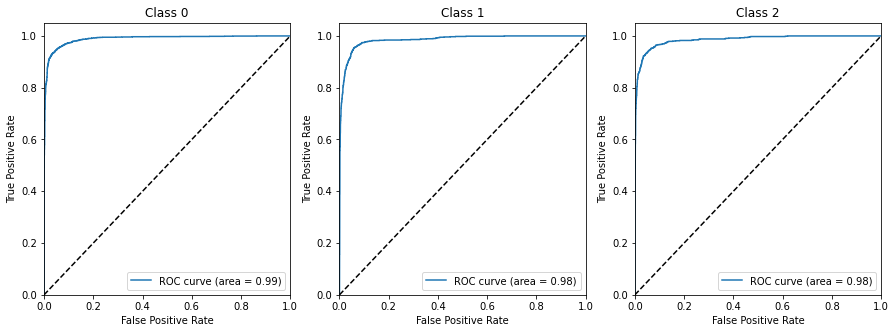

In [132]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_label_binarize[:, i], y_hat_prob[i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(15, 5))
for idx, i in enumerate(range(n_classes)):
    plt.subplot(131+idx)
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Class %0.0f' % idx)
    plt.legend(loc="lower right")
plt.show()